In [1]:
from lequa2024.data import ResultSubmission
from lequa2024.constants import (
    LEQUA2024_TASKS, 
    SAMPLE_SIZE, 
    VALID_MEASURES, 
    ORDINAL_MEASURES, 
    ERROR_TOL
)
import os
import numpy as np
from typing import Callable
  

## Function

In [2]:
# -----------------------------------------------------------------------------------------------
# evaluation measures for T1, T2, T4 (the official one is relative_absolute_error)
# -----------------------------------------------------------------------------------------------

def absolute_error(prevs, prevs_hat):
    """Computes the absolute error between the two prevalence vectors.
     Absolute error between two prevalence vectors :math:`p` and :math:`\\hat{p}`  is computed as
     :math:`AE(p,\\hat{p})=\\frac{1}{|\\mathcal{Y}|}\\sum_{y\in \mathcal{Y}}|\\hat{p}(y)-p(y)|`,
     where :math:`\\mathcal{Y}` are the classes of interest.

    :param prevs: array-like of shape `(n_classes,)` with the true prevalence values
    :param prevs_hat: array-like of shape `(n_classes,)` with the predicted prevalence values
    :return: absolute error
    """
    assert prevs.shape == prevs_hat.shape, f'wrong shape {prevs.shape} vs. {prevs_hat.shape}'
    return abs(prevs_hat - prevs).mean(axis=-1)


def relative_absolute_error(prevs, prevs_hat, eps=None):
    """Computes the absolute relative error between the two prevalence vectors.
     Relative absolute error between two prevalence vectors :math:`p` and :math:`\\hat{p}`  is computed as
     :math:`RAE(p,\\hat{p})=\\frac{1}{|\\mathcal{Y}|}\\sum_{y\in \mathcal{Y}}\\frac{|\\hat{p}(y)-p(y)|}{p(y)}`,
     where :math:`\\mathcal{Y}` are the classes of interest.
     The distributions are smoothed using the `eps` factor (see :meth:`quapy.error.smooth`).

    :param prevs: array-like of shape `(n_classes,)` with the true prevalence values
    :param prevs_hat: array-like of shape `(n_classes,)` with the predicted prevalence values
    :param eps: smoothing factor. `rae` is not defined in cases in which the true distribution contains zeros; `eps`
        is typically set to be :math:`\\frac{1}{2T}`, with :math:`T` the sample size. If `eps=None`, the sample size
        will be taken from the environment variable `SAMPLE_SIZE` (which has thus to be set beforehand).
    :return: relative absolute error
    """

    def __smooth(prevs, eps):
        n_classes = prevs.shape[-1]
        return (prevs + eps) / (eps * n_classes + 1)

    prevs = __smooth(prevs, eps)
    prevs_hat = __smooth(prevs_hat, eps)
    return (abs(prevs - prevs_hat) / prevs).mean(axis=-1)


# ---------------------------------------------------------------------------------------------------------
# evaluation measures for T3 (the official one is macro-nmd, see evaluate_submission(...metric=macro-nmd))
# ---------------------------------------------------------------------------------------------------------

def normalized_match_distance(prevs, prevs_hat):
    """
    Computes the Normalized Match Distance; which is the Normalized Distance multiplied by the factor
    `1/(n-1)` to guarantee the measure ranges between 0 (best prediction) and 1 (worst prediction).

    :param prevs: array-like of shape `(n_classes,)` with the true prevalence values
    :param prevs_hat: array-like of shape `(n_classes,)` with the predicted prevalence values
    :return: float in [0,1]
    """
    n = len(prevs)
    return (1./(n-1))*match_distance(prevs, prevs_hat)


def match_distance(prevs, prevs_hat):
    """
    Computes the Match Distance, under the assumption that the cost in mistaking class i with class i+1 is 1 in
    all cases.

    :param prevs: array-like of shape `(n_classes,)` with the true prevalence values
    :param prevs_hat: array-like of shape `(n_classes,)` with the predicted prevalence values
    :return: float
    """
    P = np.cumsum(prevs)
    P_hat = np.cumsum(prevs_hat)
    assert np.isclose(P_hat[-1], 1.0, rtol=ERROR_TOL), \
        'arg error in match_distance: the array does not represent a valid distribution'
    distances = np.abs(P-P_hat)
    return distances[:-1].sum()


# -----------------------------------------------------------------------------------------------
# common functions
# -----------------------------------------------------------------------------------------------

def eval_metric(true_prevs: np.ndarray, pred_prevs: np.ndarray, metric: Callable, average=True):
    """
    Evaluates a set of predicted prevalence values with respect to the true prevalence values in terms of
    any given evaluation metric.

    :param true_prevs: np.ndarray of shape (n_tests, n_classes), true prevalence values
    :param pred_prevs: np.ndarray of shape (n_preds, n_classes), predicted prevalence values
    :param metric: callable function, the metric computing the error between two prevalence vectors
    :param average: bool, whether to return the average or the array of errors
    """
    errors = [metric(p, p_hat) for p, p_hat in zip(true_prevs, pred_prevs)]
    errors = np.asarray(errors)
    if average:
        errors = errors.mean()
    return errors


def evaluate_submission(
        true_prevs_file: ResultSubmission,
        predicted_prevs_file: ResultSubmission,
        sample_size: int,
        measure: str,
        average=True):
    """
    Function used to evaluate a result submission file.

    :param true_prevs_file: ResultSubmission, true prevalence values (provided as part of the LeQua 2024 data)
    :param predicted_prevs_file: ResultSubmission, estimated prevalence values (computed by a participant's method)
    :param sample_size: int, number of instances per sample (depends on the task), see constants.SAMPLE_SIZE
    :param measure: str, either "rae", "ae" for tasks T1, T2, and T4, or "nmd" for T3
    :param average: bool, indicates whether the values have to be averaged before being returned
    :return: an array of error values if `average=False', or a single float if `average=True'
    """

    ntests = len(true_prevs_file)
    npreds = len(predicted_prevs_file)

    if ntests != npreds:
        raise ValueError(f'size mismatch, ground truth file has {ntests} entries '
                         f'while the file of predictions contains {npreds} entries')
    if true_prevs_file.n_categories != predicted_prevs_file.n_categories:
        raise ValueError(f'these result files are not comparable since the categories are different: '
                         f'true={true_prevs_file.n_categories} categories vs. '
                         f'predictions={predicted_prevs_file.n_categories} categories')

    assert measure in VALID_MEASURES, \
        f'unknown evaluation measure {measure}, valid ones are {VALID_MEASURES}'

    if measure in ORDINAL_MEASURES:
        assert true_prevs_file.n_categories == 5, \
            f'unexpected number of categories (found {true_prevs_file.n_categories}, expected 5) for metric {measure}'

    # extrac all prevalence vectors from the ResultSubmission files
    true_prevs_arr = np.zeros(shape=(ntests, true_prevs_file.n_categories), dtype=float)
    pred_prevs_arr = np.zeros(shape=(npreds, predicted_prevs_file.n_categories), dtype=float)
    for sample_id, true_prevalence in true_prevs_file.iterrows():
        pred_prevalence = predicted_prevs_file.prevalence(sample_id)
        true_prevs_arr[sample_id] = true_prevalence
        pred_prevs_arr[sample_id] = pred_prevalence

    # choose the evaluation metric from its name
    if measure == 'ae':
        measure_fn = absolute_error
    elif measure == 'rae':
        measure_fn = lambda p, p_hat: relative_absolute_error(p, p_hat, eps=1./(2*sample_size))
    elif measure in ORDINAL_MEASURES:
        measure_fn = normalized_match_distance

    if measure != 'macro-nmd':
        errors = eval_metric(true_prevs_arr, pred_prevs_arr, measure_fn, average=average)
    else:
        stars = np.arange(5)+1  # [1,2,3,4,5]

        # computes the average stars rate
        mean_true_stars = (stars * true_prevs_arr).sum(axis=1)

        # bins results by average stars rate in [1,2), [2,3), [3,4), [4,5]
        bin_idx = np.digitize(mean_true_stars, bins=stars)

        errors = np.zeros(shape=len(stars)-1, dtype=float)
        for star in stars[:-1]:
            select = bin_idx==star
            bin_true = true_prevs_arr[select]
            bin_pred = pred_prevs_arr[select]
            errors[star-1] = eval_metric(bin_true, bin_pred, normalized_match_distance, average=True)

        if average:
            errors = errors.mean()

    return errors

## Results

|  Methods/Error  |      MRAE      |  MAE |
|:----------|:-------------:|:------:|
| Dummy |  3.08663 ~ 13.60694  | 0.34030 ~ 0.22587 |
| CC |  1.32047 ~ 6.05854  | 0.16249 ~ 0.10693 |
| BBSE | 0.17305 ~ 0.62915 | 0.02814 ~ 0.02238 |
| MLLE | 0.11150 ~ 0.32965 | 0.02223 ~ 0.01720 |
| MeanDFM |  0.17266 ~ 0.45374  | 0.03403 ~ 0.02597 |
| RFFM | 0.17907 ~ 0.78369 |  0.03058 ~ 0.02307  |
| MahalanobisRFFM | 0.17094 ~ 0.72385  | 0.02681 ~ 0.02053 |
| FourierClassifier | 0.15437 ~ 0.54801 |  0.02518 ~ 0.02019 |
| MahalanobisFourierClassifier | 0.13678 ~ 0.47734 |  0.02264 ~ 0.01748 |

In [5]:
task = 'T2'
sample_size = SAMPLE_SIZE[task]
list_methods = ["CC", "BBSE", "MLLE", "MeanDFM", "RFFM", "MahalanobisRFFM", "FourierClassifier", "MahalanobisFourierClassifier",]

Method = CC; mrae = 3.330515636937309; mae = 0.03359957384440555
Method = BBSE; mrae = 1.8335388146032319; mae = 0.019656361441921875
Method = MLLE; mrae = 1.3298734611886205; mae = 0.014655621643390394
Method = MeanDFM; mrae = 2.2234394722030144; mae = 0.020458187599427954
Method = RFFM; mrae = 2.2873734387214055; mae = 0.021595433055524076
Method = MahalanobisRFFM; mrae = 2.2722281101072066; mae = 0.021129854081521633
Method = FourierClassifier; mrae = 1.7386485532096958; mae = 0.016769244978289622
Method = MahalanobisFourierClassifier; mrae = 1.6162888835275988; mae = 0.015235737197905623


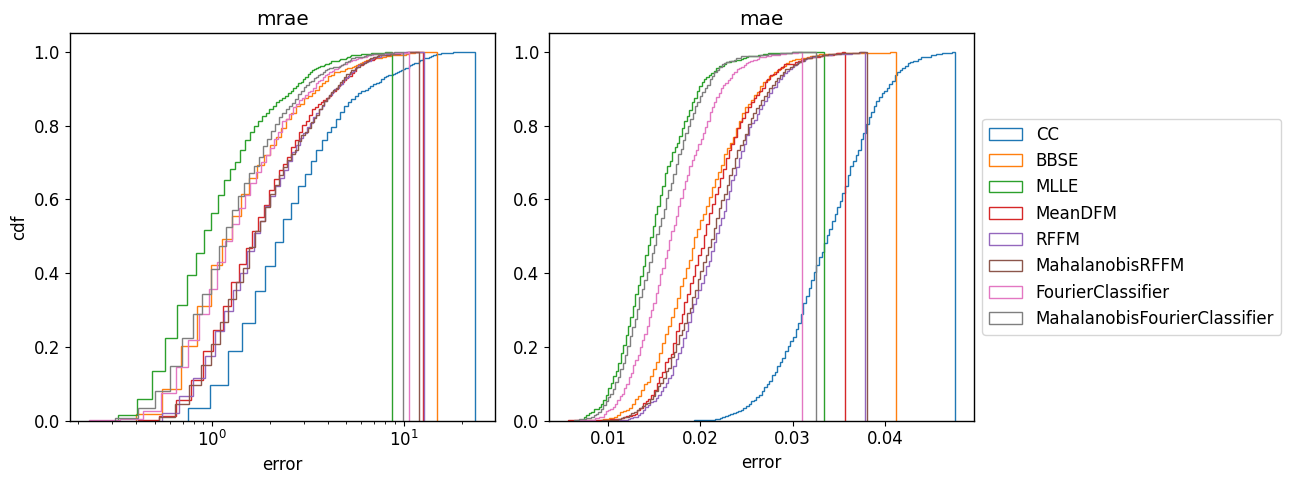

In [7]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.stats import gmean
# plot cdf

plt.style.use('default')


rcParams['font.size'] = 12
rcParams['axes.linewidth'] = 1
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.set_title('mrae')
ax2.set_title('mae')
ax1.set_xlabel('error')
ax2.set_xlabel('error')
ax1.set_ylabel('cdf')
ax1.set_xscale('log')

for method in list_methods:
    true_prev_path = os.path.join(
        os.getcwd(), f"../data/{task}.train_dev/{task}/public/dev_prevalences.txt")
    pred_prev_path = os.path.join(
        os.getcwd(), f"../results/{task}/{method}.csv")

    true_prev = ResultSubmission.load(true_prev_path)
    pred_prev = ResultSubmission.load(pred_prev_path)
    mrae = evaluate_submission(true_prev, pred_prev, sample_size, measure='rae', average=False)
    mae  = evaluate_submission(true_prev, pred_prev, sample_size, measure='ae',  average=False)
    
    ax1.hist(mrae, bins=100, density=True, histtype='step', cumulative=True, label=method)
    ax2.hist(mae, bins=100, density=True, histtype='step', cumulative=True, label=method)

    print(f"Method = {method}; mrae = {np.mean(mrae)}; mae = {gmean(mae)}")
    
plt.tight_layout()
# legend next to the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()